In [1]:
'''
Visualize impedance measurement of BioTac
Author: Yitian Shao
Created on 2022.07.08
'''

from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.patches import Arc
import pandas as pd
from scipy import signal
from scipy.interpolate import griddata
import seaborn as sns

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf')

plt.rc('font', size=10, family='Verdana') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='0.5', linewidth=0.75)
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rcParams.update({'errorbar.capsize': 4})
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

figSize_inch = (3.2, 2.4)

Fs = 100

In [2]:
'''Import PyBiotacLib instead'''
from PyBiotacLib import *

In [ ]:
# '''
# General Functions
# '''

# def unifyAxesColor(ax, color='k'):
#     ax.spines['top'].set_color(color)
#     ax.spines['left'].set_color(color)
#     ax.spines['right'].set_color(color)
#     ax.spines['bottom'].set_color(color)
#     ax.tick_params('both', colors='k')

# def decodeActuatorInfo(rootName):
#     actLabel = re.findall('Act\d+mm\d+\.\d+mL', rootName)
#     if actLabel:
#         actLabel = actLabel[0]
#     return actLabel

# def decodeData(fileName, numFormat, frontCode='', rearCode=''):
#     segStr = re.findall(frontCode+numFormat+rearCode, fileName)
#     if segStr:
#         numData = float(re.findall(numFormat, segStr[0])[0])
#     else:
#         numData = None
#     return numData

# def lowpassSmooth(datain, cutFreqRatio = 0.05, order = 8):
#     b, a = signal.butter(order, 2 * cutFreqRatio, btype='low')
#     dataout = signal.filtfilt(b, a, datain)
#     return dataout

# def loadDataSegment(measureDataPath, root, fileName, lpFreq=0.5):
#     actLabel = decodeActuatorInfo(root)
#     if actLabel:
#         tubeLen = decodeData(actLabel, '\d+', rearCode='mm')
#         infillVol = decodeData(actLabel, '[\d+\.]*\d+', rearCode='mL')   

#         vLevel = decodeData(fileName, '\d+', frontCode='v')
#         cTime = decodeData(fileName, '\d+', frontCode='c')
#         dTime = decodeData(fileName, '\d+', frontCode='d')
#         trialNum = decodeData(fileName, '\d+', frontCode='t')
#         dLabel = "L%03dF%.1fV%03dC%04dD%04d" % (tubeLen, infillVol, vLevel, cTime, dTime)  

#         print("%s --- Len=%dmm, Infill=%.1fmL, Condi: v=%d%% c=%dms d=%dms t=%d" % 
#               (dLabel, tubeLen, infillVol, vLevel, cTime, dTime, trialNum))         

#     ''' Read in data '''
#     data = np.genfromtxt(ospa.join(measureDataPath, root, fileName), delimiter=',')

#     t = data[:,0]
#     pDC = (data[:,1] - data[0,1]) * 0.0365 # DC Pressure = (Pdc - Offset) 0.0365 kPa/bit
#     tAC = data[:,2]
#     tDC = data[:,3]
    
#     eData = (4095/data[:,4:] - 1) * 10000 # (Unit: Ohm) Impedance = (4095/En - 1) 10 kOhm
# #     eData = data[:,4:] # Showing raw electrode measurement instead of converting to impedance values (2023.03.22)
    
#     ''' Smooth impedance signal '''
#     if lpFreq < 0.5 and lpFreq > 0:
#         for i in range(19):
#             eData[:,i] = lowpassSmooth(eData[:,i], cutFreqRatio=lpFreq, order = 8) # lpFreq: 0.2
            
#     eData = eData - np.mean(eData[0:20,:], axis=0) # Subtract DC (the first 0.2 sec signal)
# #     eData = eData - np.amin(eData, axis=0)

#     outData = {}
#     outData['t'] = t
#     outData['pDC'] = pDC
#     outData['tAC'] = tAC
#     outData['tDC'] = tDC
#     outData['eData'] = eData
    
#     return outData

# def examData(data, tInstance=1.5, tRange=[0, 30], dispTem=False):
#     ''' Exam data '''
#     ti = np.argmax(data['t']>=tInstance)
#     print("Selected time instance at %.2f sec, index = %d" % (tInstance, ti))
    
#     if dispTem: # Display temperature readings in addition to the dc pressure reading
#         _,(ax1, ax2, ax3)  = plt.subplots(3, 1, dpi=300, figsize=(3,2))
#         ax2.plot(data['t'], data['tAC'])
#         ax2.set_xlim(tRange)
#         ax3.plot(data['t'], data['tDC'])
#         ax3.set_xlim(tRange)
#     else:
#         _,ax1 = plt.subplots(dpi=300, figsize=(3,1))
        
#     ax1.plot(data['t'], data['pDC'])
#     ax1.plot(data['t'][[ti, ti]], [0, 3], 'k')
#     ax1.set_xlim(tRange)
    
#     _, ax = plt.subplots(dpi=300, figsize=(3,2))
#     for i in range(19):
#         ax.plot(data['t'], data['eData'][:,i])
#     ax.set_xlim(tRange)
#     ax.plot(data['t'][[ti, ti]], [-0.1, 0.1], 'k')
    
# def generateMapResult(tind, btData, yMax=1000, unifyRange=None, alpha=4000):    
# #     cmap=cm.get_cmap('rainbow', 100) # cmap=cm.get_cmap('inferno', 100)
# #     cmap=cm.get_cmap('binary', 100) # cmap=cm.get_cmap('RdYlBu', 100)
#     cmap=cm.get_cmap('viridis', 100)

#     btMap = BiotacMap()
#     btMap.initializeDistanceMap(alpha=alpha)

#     frameNum = len(tind)
    
#     ''' Remove DC of electrode measurement '''
#     eData = btData['eData']
#     eData = eData - np.mean(eData[tind[0]:tind[1],:], axis=0) 

#     fig0, axes = plt.subplots(1, frameNum, dpi=300, figsize=figSize_inch)
#     for i in range(frameNum):
#         btMap.mapFromCubicInterp(axes[i], eData[tind[i],:])
#         axes[i].set_title("%.2fs" % btData['t'][tind[i]], size=3)

#     ''' Smooth interpolation of impedance map '''
#     mapValues = []
#     mapMins = []
#     mapMaxs = []
#     for i in range(frameNum):
#         mapValue = btMap.constructMap(eData[tind[i],:])
#         mapValues.append(mapValue)
#         mapMins.append(np.amin(mapValue))
#         mapMaxs.append(np.amax(mapValue))
    
#     if unifyRange is None:
#         unifyRange = [min(mapMins), max(mapMaxs)]

#     fig1, ax0 = plt.subplots(dpi=300, figsize=(3,1))
#     fig1cbar, cbarax = plt.subplots(dpi=300, figsize=(1,1))
#     btMap.dispMaps(ax0, mapValues, xShift=300, cbarax=cbarax, cmap=cmap, unifyRange=unifyRange, s=0.001, dispOutline=False)

#     ''' Plot Signal waveform '''  
#     fig2, ax1 = plt.subplots(dpi=300, figsize=(3,1))
#     ax1.plot(btData['t'], btData['pDC'])

#     for i in range(frameNum):
#         ax1.plot(btData['t'][[tind[i], tind[i]]], [0, yMax], 'tab:grey', lw=0.5)

#     ax1.set_xlim([btData['t'][tind[0]]-0.1, btData['t'][tind[-1]]+0.1]);
#     if(yMax < 1000):
#         ax1.set_ylim([-0.1, yMax])
#     unifyAxesColor(ax1, color='k')

#     ax1.set_xlabel("Time (secs)")
#     ax1.set_ylabel("Pressure (kPa)");
    
#     return fig1, fig1cbar, fig2, ax1

In [ ]:
# '''
# Class
# '''
# class BiotacMap:
#     ''' Class of biotac mapping for impedance data visualization '''
#     def __init__(self):
#         ''' Biotac Electrode 1-19 layout '''
#         eXY = [[278, 523], [226, 588], [226, 639], [278, 666], [226, 704], [278, 757],
#                [174, 458], [213, 497], [135, 497], [174, 536], [69, 523], [122, 588],
#                [122, 639], [69, 665], [122, 704], [69, 756], [174, 587], [174, 691], [174, 756]]
#         eXY = np.array(eXY)
#         eXY[:,1] = -eXY[:,1]+800

#         self.eXY = eXY
#         self.eNum = eXY.shape[0]
        
#         extent = (50,300,0,400)
#         self.extent = extent
        
#         self.grid_x, self.grid_y = np.mgrid[extent[0]:extent[1], extent[2]:extent[3]]
        
#         ''' Finger-shape mapping: Set electrode 10 eXY[9,:] as the arc center of the shape '''
#         self.centerX = self.eXY[9,0]
#         self.centerY = self.eXY[9,1]
#         self.bottomY = self.eXY[18,1] - 20
#         self.cRadius = 125

#         ''' Biotac finger shape '''
#         grid_x, grid_y = np.mgrid[(self.centerX-self.cRadius):(self.centerX+self.cRadius), 
#                                   self.bottomY:(self.centerY+self.cRadius)]
#         gridXY = np.vstack((grid_x.flatten(),grid_y.flatten())).T

#         ind = (gridXY[:,1] <= self.centerY) | ((gridXY[:,1] > self.centerY) & 
#               ((np.square(gridXY[:,0]-self.centerX) + np.square(gridXY[:,1]-self.centerY)) < (self.cRadius*self.cRadius)))
#         self.gridXY = gridXY[ind,:]
        
#     ''' Compute distance map '''    
#     def initializeDistanceMap(self, alpha=100): # Alpha determine the smoothness of the map: Phi = 1/(dist + Alpha)
#         distMap = []
#         for i in range(self.eNum):
#             aDistance = np.sqrt(np.square(self.gridXY[:,0]-self.eXY[i,0]) + np.square(self.gridXY[:,1]-self.eXY[i,1]))
#             distMap.append(aDistance)
            
#         self.distMap = np.array(distMap)

#         self.Phi = 1 / (np.square(self.distMap) + alpha)
        
# #         self.Phi[self.Phi < 3e-3] = 0
        
#         self.SumPhi = np.sum(self.Phi, axis=0)
    
#     def dispElectrode(self, ax, s=100, fontsize=5, fontcolor='w'):
#         for ei in range(self.eNum):
#             ax.scatter(self.eXY[ei,0], self.eXY[ei,1], s=s, c='darkslategrey')
#             ax.text(self.eXY[ei,0]-12, self.eXY[ei,1]-5, ("E%d" % (ei+1)), fontsize=fontsize, color=fontcolor)
#         ax.set_aspect('equal',adjustable='box')
    
#     def dispFingerLayout(self, ax, lw=1):
#         arcObj = Arc([self.centerX, self.centerY], 2*self.cRadius, 2*self.cRadius, angle=0, theta1=0.0, 
#                 theta2=180.0, color='turquoise', lw=lw)
#         ax.add_patch(arcObj)
#         ax.plot([self.centerX-self.cRadius, self.centerX-self.cRadius], [self.bottomY, self.centerY], color='turquoise', lw=lw)
#         ax.plot([self.centerX+self.cRadius, self.centerX+self.cRadius], [self.bottomY, self.centerY], color='turquoise', lw=lw)
#         ax.plot([self.centerX-self.cRadius, self.centerX+self.cRadius], [self.bottomY, self.bottomY], color='turquoise', lw=lw)
#         ax.set_aspect('equal',adjustable='box')
        
#     def dispFingerSurface(self, ax):
#         ax.plot(self.gridXY[:,0], self.gridXY[:,1], color='turquoise', lw=0.1)
        
#     def constructMap(self, eValue):
#         mapValue = np.matmul(eValue, self.Phi) / self.SumPhi
#         return mapValue
        
#     def dispMaps(self, ax, mapValues, xShift=0, cbarax=None, cmap=cm.get_cmap('Greys', 100), unifyRange=[0, 1], 
#                  s=0.1, dispOutline=False):      
#         frameNum = len(mapValues)
        
#         for i in range(frameNum):
#             scplt = ax.scatter(xShift*i+self.gridXY[:,0], self.gridXY[:,1], c=mapValues[i], cmap=cmap, s=s, norm=None, 
#                        vmin=unifyRange[0], vmax=unifyRange[1])

#         ax.set_aspect('equal',adjustable='box')

#         ax.set_xlim([self.centerX-self.cRadius, xShift*i+self.centerX+self.cRadius])
#         ax.set_ylim([self.bottomY, self.centerY + self.cRadius + 10])
        
#         ax.axis('off')
        
#         if cbarax is None:
#             cbarax = ax
            
#         cbar = plt.colorbar(scplt, ax=cbarax, fraction=0.05, pad=0.25, aspect=8)
#         cbar.outline.set_visible(False)
#         cbar.ax.get_yaxis().labelpad = 15
#         cbar.ax.set_ylabel(r'$\Delta_{\mathrm{Impedance}} (\Omega$)', rotation=270)
        
#         if dispOutline:
#             self.dispFingerLayout(ax)
        
#         return cbar
        
#     def mapFromCubicInterp(self, ax, eValue, dispNode=False): # (Obsolete) Interpolation cubically between electrodes 
#         grid_z = griddata(self.eXY, eValue, (self.grid_x, self.grid_y), method='cubic')
        
#         ax.imshow(grid_z.T, extent=self.extent, origin='lower', cmap='gray')
        
#         if dispNode:
#             self.dispElectrode(ax)
            
#         ax.set_aspect('equal',adjustable='box')
#         ax.axis('off')

In [ ]:
''' Visualize biotac electrode layout '''
### eValue = np.random.rand(19,)
eValue = np.zeros(19,)

btMap = BiotacMap()
btMap.initializeDistanceMap()

fig1, ax = plt.subplots(dpi=300, figsize=figSize_inch)

# btMap.constructMap(ax, eValue, dispOutline=True)
btMap.dispFingerSurface(ax)
btMap.dispFingerLayout(ax, lw=1)
btMap.dispElectrode(ax)
ax.axis('off');

# fig1.savefig("ElectrodeLayout.pdf", bbox_inches='tight', dpi=300)

In [ ]:
''' Visualize real data and Biotac electrode impedance map: Charge time = 0.1 secs '''
# measureDataPath = ".\Data2022.06.26"
# root = 'Act90mm1.8mL'; fileName = 'v100c100d4000t1.btd.csv' 
# tInstance = 30.0
# tRange=[2, 3] 

# btData = loadDataSegment(measureDataPath, root, fileName, lpFreq=0.25)
# # examData(btData, tInstance=tInstance, tRange=tRange, dispTem=False)

# btData['t'] = btData['t'] - 2.259999

# tind = np.arange(225,243, 2) # 'Act90mm1.8mL' 'v100c100d4000t1.btd.csv' '''[Included]'''

# fig1, fig1cbar, fig2, ax1 = generateMapResult(tind, btData, yMax=2, unifyRange=None)

# ax1.set_xticks([0, 0.08, 0.16]);
# ax1.set_yticks([0, 1, 2]);


# fig1.savefig("Act90mm1.8mLv100c0.1sec_maps.png", bbox_inches='tight', dpi=600)
# fig1cbar.savefig("Act90mm1.8mLv100c0.1sec_cbar.pdf", bbox_inches='tight', dpi=300)
# fig2.savefig("Act90mm1.8mLv100c0.1sec_signal.pdf", bbox_inches='tight', dpi=300)

In [ ]:
''' Visualize real data and Biotac electrode impedance map: Charge time = 0.4 secs '''
measureDataPath = ".\Data2022.06.26"
root = 'Act90mm1.8mL'; fileName = 'v100c400d4000t1.btd.csv' 
tInstance = 30.0
tRange=[5.1, 15.7] 

btData = loadDataSegment(measureDataPath, root, fileName, lpFreq=0.25)
# examData(btData, tInstance=tInstance, tRange=tRange, dispTem=False)

btData['t'] = btData['t'] - 5.70

tind = np.arange(569,630, 7) # tind = np.arange(564,630, 8) # 'Act90mm1.8mL' # tind = np.arange(1500, 1580, 10) #t2

fig1, fig1cbar, fig2, ax1 = generateMapResult(tind, btData, yMax=4, unifyRange=[-10, 10])

ax1.set_yticks([0, 2, 4]);

# fig1.savefig("Act90mm1.5mLv100c0.4sec_maps.png", bbox_inches='tight', dpi=600)
# fig1cbar.savefig("Act90mm1.5mLv100c0.4sec_cbar.pdf", bbox_inches='tight', dpi=300)
# fig2.savefig("Act90mm1.5mLv100c0.4sec_signal.pdf", bbox_inches='tight', dpi=300)

In [ ]:
''' Visualize real data '''
# measureDataPath = ".\Data2022.06.26"

# # root ='Act110mm1.8mL'; fileName = 'v100c400d4000t1.btd.csv'
# root = 'Act90mm1.8mL'; fileName = 'v100c1200d4000t1.btd.csv' 

# tInstance = 30.0
# tRange=[1, 3] 

# btData = loadDataSegment(measureDataPath, root, fileName, lpFreq=0.25)
# # examData(btData, tInstance=tInstance, tRange=tRange, dispTem=False)

# btData['t'] = btData['t'] - 1.2

# ''' Visualize Biotac electrode impedance map: Charge time = 1.2 secs '''
# # tind = np.arange(116,198,10) # 'Act110mm1.8mL' 'v100c400d4000t1.btd.csv'
# # tind = np.arange(192,333,20) # 'Act110mm1.8mL' 'v100c800d4000t1.btd.csv'
# # tind = 1560+np.arange(140,321,20) # 'Act60mm1.5mL' 'v100c1200d4000t1.btd.csv' 


# tind = np.arange(119,290, 20) #'Act90mm1.5mL' 'v100c1200d4000t1.btd.csv' '''[Included]'''

# fig1, fig1cbar, fig2, ax1 = generateMapResult(tind, btData, yMax=5, ) #unifyRange=[-10, 10]

# ax1.set_yticks([0, 2.5, 5]);


# fig1.savefig("Act90mm1.5mLv100c1.2sec_maps.png", bbox_inches='tight', dpi=600)
# fig1cbar.savefig("Act90mm1.5mLv100c1.2sec_cbar.pdf", bbox_inches='tight', dpi=300)
# fig2.savefig("Act90mm1.5mLv100c1.2sec_signal.pdf", bbox_inches='tight', dpi=300)

In [ ]:
measureDataPath = ".\Data2022.06.26"
root = 'Act60mm1.5mL'; fileName = 'v100c1200d4000t1.btd.csv' 
tInstance = 30.0
tRange=[6.8, 8.6] 

btData = loadDataSegment(measureDataPath, root, fileName, lpFreq=0.25)
# examData(btData, tInstance=tInstance, tRange=tRange, dispTem=False)

tind = np.arange(687, 860, 20) # 'Act60mm1.5mL'

btData['t'] = btData['t'] - 6.87999

# fig1, fig1cbar, fig2, ax1 = generateMapResult(tind, btData, yMax=5.2, unifyRange=[-25, 25]) #

# ax1.set_xlim([-0.1, 1.7]);
# ax1.set_xticks([0, 0.8, 1.6]);
# ax1.set_yticks([0, 2.5, 5]);

# fig1.savefig("Act60mm1.5mLv100c1.2sec_maps.png", bbox_inches='tight', dpi=600)
# fig1cbar.savefig("Act60mm1.5mLv100c1.2sec_cbar.pdf", bbox_inches='tight', dpi=300)
# fig2.savefig("Act60mm1.5mLv100c1.2sec_signal.pdf", bbox_inches='tight', dpi=300)


''' To plot all waveforms in one axis '''
Act60v100c1200 = {}
Act60v100c1200['t'] = btData['t']
Act60v100c1200['pDC'] = btData['pDC']
Act60v100c1200['tind'] = tind

In [ ]:
''' 
Additional results


Visualize real data and Biotac electrode impedance map 
'''

measureDataPath = ".\Data2022.06.26"
root = 'Act60mm1.5mL'; fileName = 'v100c400d4000t1.btd.csv' 
tInstance = 30.0
tRange=[1.2, 2] 

btData = loadDataSegment(measureDataPath, root, fileName, lpFreq=0.25)
# examData(btData, tInstance=tInstance, tRange=tRange, dispTem=False)

tind = np.arange(128, 190, 7) # 'Act60mm1.5mL'

btData['t'] = btData['t'] - 1.28999

# fig1, fig1cbar, fig2, ax1 = generateMapResult(tind, btData, yMax=4, unifyRange=[-25, 25])

# ax1.set_xlim([-0.05, 0.65]);
# ax1.set_xticks([0, 0.3, 0.6]);
# ax1.set_yticks([0, 2, 4]);

# fig1.savefig("Act60mm1.5mLv100c0.4sec_maps.png", bbox_inches='tight', dpi=600)
# fig1cbar.savefig("Act60mm1.5mLv100c0.4sec_cbar.pdf", bbox_inches='tight', dpi=300)
# fig2.savefig("Act60mm1.5mLv100c0.4sec_signal.pdf", bbox_inches='tight', dpi=300)

''' To plot all waveforms in one axis '''
Act60v100c400 = {}
Act60v100c400['t'] = btData['t']
Act60v100c400['pDC'] = btData['pDC']
Act60v100c400['tind'] = tind

In [ ]:
measureDataPath = ".\Data2022.06.26"
# root = 'Act60mm1.5mL'; fileName = 'v100c200d4000t2.btd.csv' 
# tInstance = 30.0
# tRange=[1.0, 1.8] 

# btData = loadDataSegment(measureDataPath, root, fileName, lpFreq=0.25)
# # examData(btData, tInstance=tInstance, tRange=tRange, dispTem=False)

# tind = np.arange(120, 160, 5) # 'Act60mm1.5mL'

# fig1, fig1cbar, fig2, ax1 = generateMapResult(tind, btData, yMax=5.2, unifyRange=[-28, 28]) #unifyRange=[-16, 16])

In [ ]:
measureDataPath = ".\Data2022.06.26"
root = 'Act60mm1.5mL'; fileName = 'v100c100d4000t1.btd.csv' 
tInstance = 30.0
tRange=[1.1, 1.6] 

btData = loadDataSegment(measureDataPath, root, fileName, lpFreq=0.25)
# examData(btData, tInstance=tInstance, tRange=tRange, dispTem=False)

tind = np.arange(124, 151, 3) # 'Act60mm1.5mL'

btData['t'] = btData['t'] - 1.24999

# fig1, fig1cbar, fig2, ax1 = generateMapResult(tind, btData, yMax=1.0, unifyRange=[-25, 25]) #[-7, 7])

# ax1.set_xlim([-0.02, 0.26]);
# ax1.set_xticks([0, 0.12, 0.24]);
# ax1.set_yticks([0, 0.5, 1.0]);

# fig1.savefig("Act60mm1.5mLv100c0.1sec_maps.png", bbox_inches='tight', dpi=600)
# fig1cbar.savefig("Act60mm1.5mLv100c0.1sec_cbar.pdf", bbox_inches='tight', dpi=300)
# fig2.savefig("Act60mm1.5mLv100c0.1sec_signal.pdf", bbox_inches='tight', dpi=300) 

''' To plot all waveforms in one axis '''
Act60v100c100 = {}
Act60v100c100['t'] = btData['t']
Act60v100c100['pDC'] = btData['pDC']
Act60v100c100['tind'] = tind

In [ ]:
''' To plot all waveforms in one axis for Act60v100c1200, Act60v100c400, Act60v100c100'''
def plotPressureSignal(dictin, ax, tindMargin=50, tShfit=0, yMax=5):
    indRange = [dictin['tind'][0]-tindMargin, dictin['tind'][-1]+tindMargin]
    ydata = dictin['pDC'][indRange[0]:indRange[1]]
    ydata = ydata - ydata[0]
 
    frameNum = len(dictin['tind'])
    for i in range(frameNum):
        ax.plot(dictin['t'][[dictin['tind'][i], dictin['tind'][i]]] + tShfit, [0, yMax], 'tab:grey', lw=0.5)
        
    ax.plot(dictin['t'][indRange[0]:indRange[1]] + tShfit, ydata) 
    ax.set_ylim([-0.1, yMax])

def plotCtrlSignal(ax, tOn=100, tMargin=200, tShift=0):
    segLen = 1600
    y = np.zeros((segLen,1))
    y[tMargin:tMargin+tOn] = 1
    x = np.arange(segLen)
    ax.plot((x + tShift - tMargin)/1000, y, 'tab:grey')
    
    
fig0, axes = plt.subplots(2, 1, dpi=300, figsize=(3.2, 0.6))
plotPressureSignal(Act60v100c100, axes[0])
plotPressureSignal(Act60v100c400, axes[0], tShfit=1.6)
plotPressureSignal(Act60v100c1200, axes[0], tShfit=3.6)

axes[0].set_xlim([-0.2, 5.8])

plotCtrlSignal(axes[1], tOn=100, tShift=0)
plotCtrlSignal(axes[1], tOn=400, tShift=1600)
plotCtrlSignal(axes[1], tOn=1200, tShift=3600)

axes[1].set_xlim([-0.2, 5.8])

fig0.savefig("CombineAllSignals.pdf", bbox_inches='tight', dpi=300)

In [ ]:
# measureDataPath = ".\Data2022.06.26"
# root = 'Act110mm1.8mL'; fileName = 'v100c1200d4000t2.btd.csv' 
# tInstance = 30.0
# tRange=[1.5, 3.4] 

# btData = loadDataSegment(measureDataPath, root, fileName, lpFreq=0.25)
# # examData(btData, tInstance=tInstance, tRange=tRange, dispTem=False)

# tind = np.arange(159, 330, 21) # 'Act110mm1.8mL'

# fig1, fig1cbar, fig2, ax1 = generateMapResult(tind, btData, yMax=5)

# fig1.savefig("Act110mm1.8mLv100c1.2sec_maps.png", bbox_inches='tight', dpi=600)
# fig1cbar.savefig("Act110mm1.8mLv100c1.2sec_cbar.pdf", bbox_inches='tight', dpi=300)
# fig2.savefig("Act110mm1.8mLv100c1.2sec_signal.pdf", bbox_inches='tight', dpi=300)

centerPress.btd.csv
Selected time instance at 1.50 sec, index = 150
rawRange = [-162.85, 200.80]


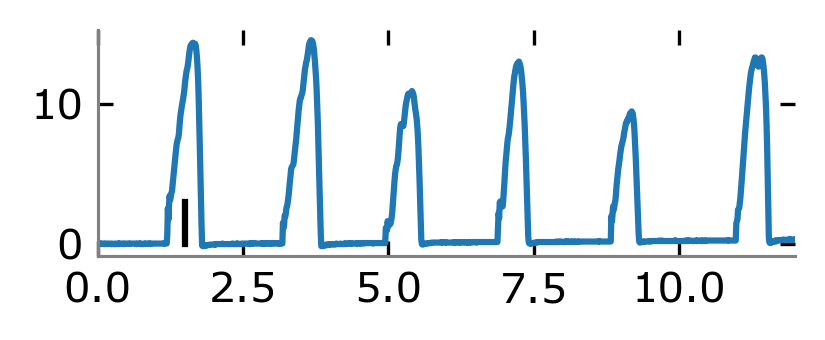

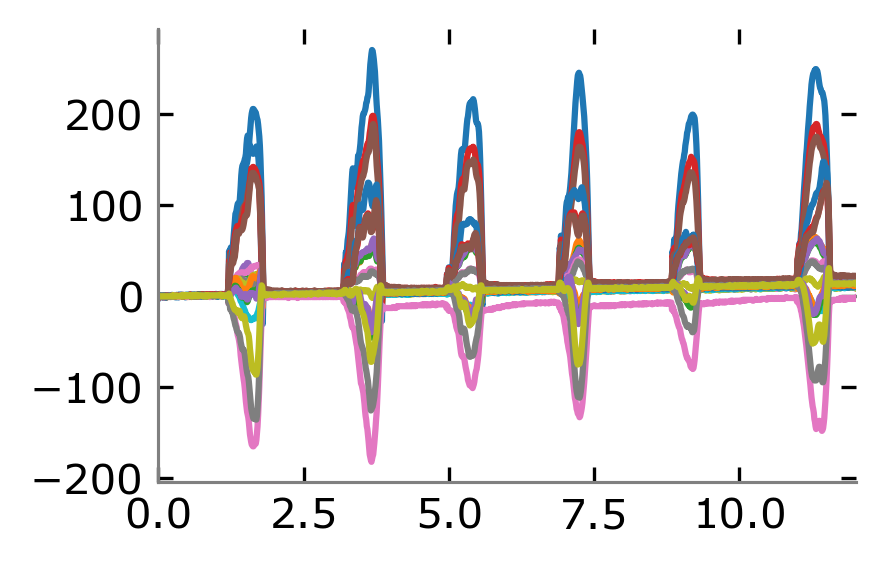

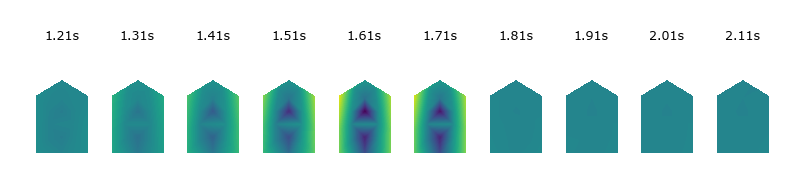

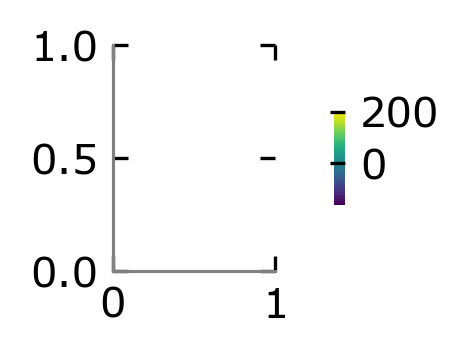

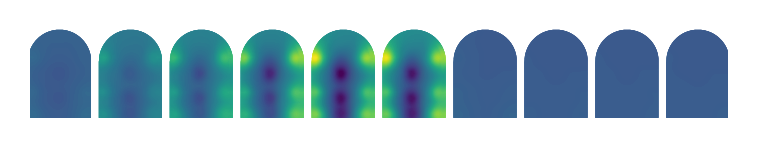

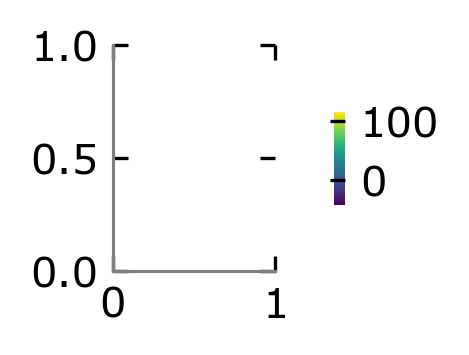

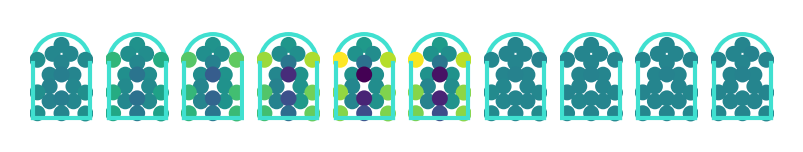

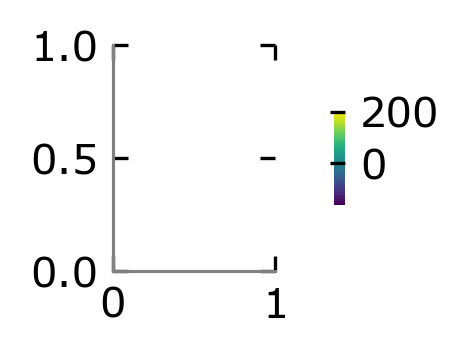

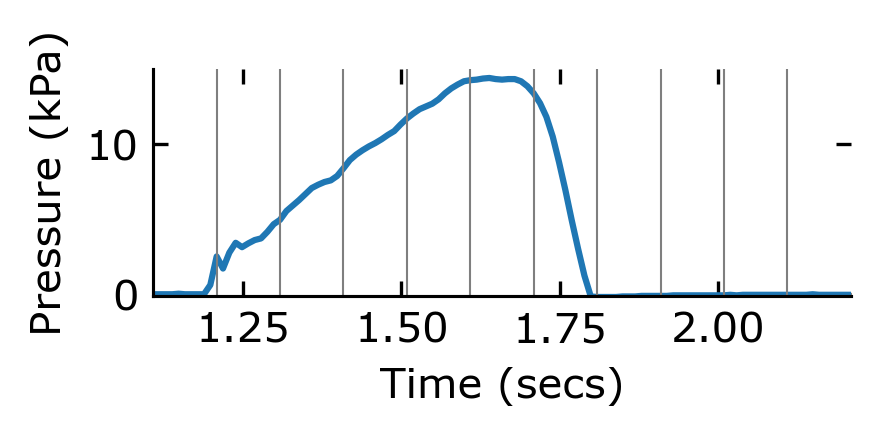

In [3]:
''' 
Visualize pesudo data (press on table) and Biotac electrode impedance map 
To evaluate the electrode measurement inaccuracy of the biotac sensor
'''

measureDataPath = ".\Data2022.07.12PressTable"

root = 'PressTable'; 

fileNames = ['centerPress.btd.csv' , 'leftPress.btd.csv', 'rightPress.btd.csv' , 'leftCorner.btd.csv' , 'rightCorner.btd.csv']

tInstance = 30.0
tRange=[3, 5] 

lpFreq=0.5

# for fileName in fileNames:
for fileName in ['centerPress.btd.csv']:
    print(fileName)
    if(fileName == 'centerPress.btd.csv'):
#         tind = np.arange(300, 400, 10) # Center
        tind = np.arange(120, 220, 10) # Center
    elif(fileName == 'leftPress.btd.csv'):
        tind = np.arange(350, 450, 10) # Left
    elif(fileName == 'rightPress.btd.csv'):
        tind = np.arange(300, 400, 10) # right
    elif(fileName == 'leftCorner.btd.csv'):
        tind = np.arange(420, 500, 8) # leftCorner
    elif(fileName == 'rightCorner.btd.csv'):
        tind = np.arange(320, 400, 8) # rightCorner
        
#     ''' Read in data '''
#     data = np.genfromtxt(ospa.join(measureDataPath, root, fileName), delimiter=',')

#     t = data[:,0]
#     pDC = (data[:,1] - data[0,1]) * 0.0365 # DC Pressure = (Pdc - Offset) 0.0365 kPa/bit
#     tAC = data[:,2]
#     tDC = data[:,3]
#     eData = (4095/data[:,4:] - 1) * 10000 # (Unit: Ohm) Impedance = (4095/En - 1) 10 kOhm

#     ''' Smooth impedance signal '''
#     if lpFreq < 0.5 and lpFreq > 0:
#         for i in range(19):
#             eData[:,i] = lowpassSmooth(eData[:,i], cutFreqRatio=lpFreq, order = 8) # lpFreq: 0.2

#     eData = eData - np.mean(eData[0:20,:], axis=0) # Subtract DC (the first 0.2 sec signal)

#     btData = {}
#     btData['t'] = t
#     btData['pDC'] = pDC
#     btData['tAC'] = tAC
#     btData['tDC'] = tDC
#     btData['eData'] = eData

    btData = loadRawBioTac(measureDataPath, fileName, root)

#     examData(btData, tInstance=tInstance, tRange=tRange, dispTem=False)
    examData(btData, tRange=[0, 12])

    fig1, fig1cbar, fig2, ax1 = generateMapResult(tind, btData, yMax=15, alpha=1000)
    plt.show()
    
    